In [3]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf

In [4]:
# Establecer una semilla para reproducibilidad
seed_value = 42
random.seed(seed_value)        # Semilla para Python
np.random.seed(seed_value)     # Semilla para NumPy
tf.random.set_seed(seed_value) # Semilla para TensorFlow/Keras

# A partir de aquí, puedes continuar con la construcción y entrenamiento de tu modelo de Keras

In [5]:
def generatePlot(history):
    # Extracción de datos
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Creación del gráfico de accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training')
    plt.plot(epochs, val_acc, 'r', label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Creación del gráfico de loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

## MNIST

In [12]:
# Cargar el conjunto de datos MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocesar los datos (escalarlos entre 0 y 1 y convertir las etiquetas a one-hot encoding)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255 # el 255 es para normalizar, 255 es el valor maximo de un pixel
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255
# one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

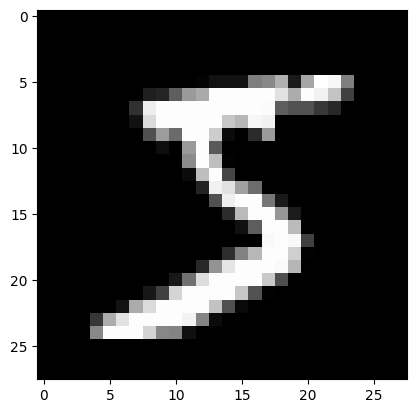

In [13]:
#imprime una imagen
plt.imshow(x_train[0].reshape(28, 28), cmap='gray')

In [14]:
# Construir el modelo
model = Sequential()
# parte convolucional
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Aplanar la salida de la capa convolucional
# parte fully connected (clasificador)
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) # Dropout para reducir overfitting
model.add(Dense(10, activation='softmax'))

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1179776   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

In [16]:
# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history_of_train = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_test, y_test))

Epoch 1/10
469/469 [==============================] - 30s 63ms/step - loss: 0.2419 - accuracy: 0.9270 - val_loss: 0.0521 - val_accuracy: 0.9819
Epoch 2/10
469/469 [==============================] - 31s 66ms/step - loss: 0.0841 - accuracy: 0.9749 - val_loss: 0.0355 - val_accuracy: 0.9877
Epoch 3/10
469/469 [==============================] - 31s 66ms/step - loss: 0.0582 - accuracy: 0.9819 - val_loss: 0.0317 - val_accuracy: 0.9888
Epoch 4/10
469/469 [==============================] - 31s 66ms/step - loss: 0.0509 - accuracy: 0.9841 - val_loss: 0.0309 - val_accuracy: 0.9895
Epoch 5/10
469/469 [==============================] - 30s 65ms/step - loss: 0.0407 - accuracy: 0.9870 - val_loss: 0.0329 - val_accuracy: 0.9900
Epoch 6/10
469/469 [==============================] - 33s 71ms/step - loss: 0.0364 - accuracy: 0.9888 - val_loss: 0.0309 - val_accuracy: 0.9902
Epoch 7/10
469/469 [==============================] - 30s 64ms/step - loss: 0.0313 - accuracy: 0.9898 - val_loss: 0.0303 - val_accuracy:

In [24]:
# Evaluar el modelo
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ValueError: in user code:

    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 150, 150, 3), found shape=(None, 28, 28, 1)


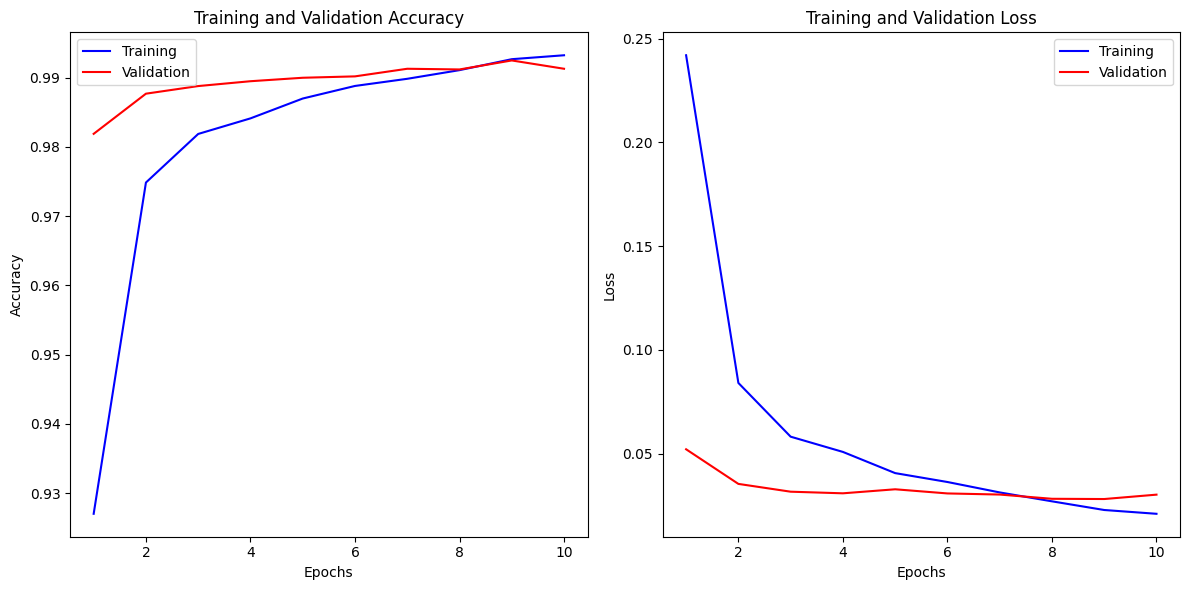

In [18]:
generatePlot(history_of_train)

## Datos propios

Este ejemplo es con este conjunto de datos: https://www.kaggle.com/datasets/anshtanwar/jellyfish-types

In [17]:
from keras.preprocessing.image import ImageDataGenerator
import os

image_size = 150
data_dir = os.path.join('data')
batch_size = 16
rescale_factor = 1./255

# Crear un generador para aumentar datos
train_datagen = ImageDataGenerator(
    rescale=rescale_factor,    # Normalizar los valores de los píxeles
    shear_range=0.2,   # Rango para las transformaciones aleatorias
    zoom_range=0.1,    # Rango para el zoom aleatorio
    horizontal_flip=True, # Activar el giro horizontal aleatorio
)

# Cargar imágenes de entrenamiento
train_generator = train_datagen.flow_from_directory(
    data_dir,      # Directorio con datos
    target_size=(image_size, image_size), # Cambiar el tamaño de las imágenes a 50x50
    batch_size=batch_size,
    class_mode='categorical', # 'binary' para clasificación binaria, 'categorical' para multiclase
    subset='training') # Seleccionar solo el conjunto de entrenamiento

# Cargar imágenes de validación
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # Seleccionar solo el conjunto de validación

Found 8458 images belonging to 3 classes.
Found 0 images belonging to 3 classes.


Te habrás dado cuenta que ImageDataGenerator no divide en conjunto de test, es que no puede. Para añadir un conjunto de test al trabajar con `ImageDataGenerator` en Keras, necesitas un enfoque ligeramente diferente, ya que `ImageDataGenerator` por sí solo no proporciona una forma directa de dividir los datos en tres conjuntos (entrenamiento, validación y prueba). Aquí hay dos métodos comunes para hacerlo:

### Método 1: División Manual de los Datos
1. **Dividir Manualmente los Datos en Directorios**: Antes de usar `ImageDataGenerator`, divide tus datos manualmente en tres directorios: uno para entrenamiento, uno para validación y otro para pruebas. Por ejemplo:
    ```
    data/
        train/
            class1/
            class2/
        validation/
            class1/
            class2/
        test/
            class1/
            class2/
    ```
2. **Crear Generadores Separados**: Usa `ImageDataGenerator` para crear generadores separados para cada conjunto de datos.

    ```python
    train_datagen = ImageDataGenerator(rescale=1./255, ...)
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        'data/train/', ...)
    validation_generator = validation_datagen.flow_from_directory(
        'data/validation/', ...)
    test_generator = test_datagen.flow_from_directory(
        'data/test/', ...)
    ```

### Método 2: Uso del Conjunto de Validación como Test
1. **Usar `validation_split` para Dividir Entrenamiento y Validación**: Primero, divide tus datos en entrenamiento y validación usando `validation_split` en `ImageDataGenerator`.

2. **Separar un Conjunto de Pruebas Después**: Después del entrenamiento, puedes apartar manualmente una parte de tu conjunto de validación (o entrenamiento) para usarlo como conjunto de prueba. Esto puede hacerse seleccionando un conjunto de imágenes y evaluando el modelo en ellas.

    ```python
    # Ya tienes train_generator y validation_generator

    # Después del entrenamiento, usa parte de validation_generator como test set
    # Por ejemplo, puedes hacer predicciones en un subconjunto de validation_generator
    # y evaluar el rendimiento del modelo
    ```

### Consideraciones Adicionales
- **Equilibrio de Clases**: Asegúrate de que cada conjunto (entrenamiento, validación, prueba) tenga una distribución similar de clases.
- **No Aumentación en Test**: Generalmente, no se aplican técnicas de aumentación de datos en el conjunto de prueba, solo el reescalado.
- **Consistencia en el Preprocesamiento**: Asegúrate de que el preprocesamiento (como el reescalado) sea consistente en todos los generadores.
- **Tamaño del Conjunto de Pruebas**: Decide cuántos datos deseas reservar para las pruebas. Un tamaño común para el conjunto de pruebas es entre el 10% y el 20% del conjunto de datos total.

Al elegir entre estos métodos, considera el tamaño de tu conjunto de datos y tus requisitos específicos de validación y prueba. La división manual en directorios ofrece la mayor flexibilidad y control.

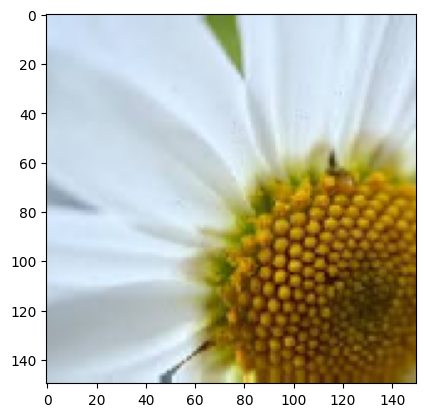

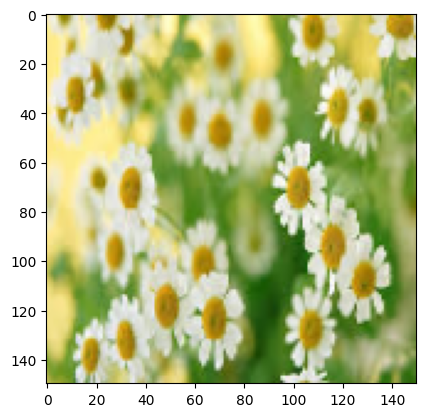

In [18]:
# ver imagenes
x_batch, y_batch = next(train_generator)
for i in range (0, 2):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()

In [19]:
model = Sequential()
# Capas convolucionales
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_size, image_size, 3))) # 3 canales de color
model.add(Dropout(0.25))  # Dropout después de la capa de conv2D
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Aplanar la salida de la capa convolucional
# Capas fully connected (clasificador)
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout antes de la capa de salida
model.add(Dense(5, activation='softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 dropout_2 (Dropout)         (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 175232)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               22429824  
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

#### Configurar Early Stopping

Early Stopping es una forma de detener el entrenamiento automáticamente cuando una métrica monitoreada deja de mejorar. Configúralo como un callback en Keras:

In [20]:
from keras.callbacks import EarlyStopping

# Configurar Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # 'patience' es el número de épocas sin mejora después de las cuales el entrenamiento se detendrá

#### Añadir Early Stopping al Entrenamiento

Cuando entrenes tu modelo, pasa el callback de Early Stopping a través del argumento callbacks:

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 10

# Entrenar el modelo con Early Stopping
history_of_train = model.fit(
        train_generator,
        epochs=epochs,
        validation_data = validation_generator,
        callbacks = [early_stopping]
)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/juancarlosacostaperaba/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/juancarlosacostaperaba/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1077, in launch_instance

  File "/Users/juancarlosacostaperaba/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/juancarlosacostaperaba/Library/Python/3.11/lib/python/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/juancarlosacostaperaba/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 529, in dispatch_queue

  File "/Users/juancarlosacostaperaba/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 518, in process_one

  File "/Users/juancarlosacostaperaba/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 424, in dispatch_shell

  File "/Users/juancarlosacostaperaba/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 766, in execute_request

  File "/Users/juancarlosacostaperaba/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/Users/juancarlosacostaperaba/Library/Python/3.11/lib/python/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/juancarlosacostaperaba/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/Users/juancarlosacostaperaba/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/Users/juancarlosacostaperaba/Library/Python/3.11/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/juancarlosacostaperaba/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/Users/juancarlosacostaperaba/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/Users/juancarlosacostaperaba/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/var/folders/nb/20z3p3gx7n79h046_62z536c0000gn/T/ipykernel_24459/121313440.py", line 5, in <module>

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/losses.py", line 2221, in categorical_crossentropy

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/backend.py", line 5579, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[16,5] labels_size=[16,3]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_2337]

In [23]:
generatePlot(history_of_train)

NameError: name 'history_of_train' is not defined

#### test

In [ ]:
# Evaluar el modelo en el conjunto de validación (usado aquí como prueba)
# Puedes limitar el número de pasos para usar solo una parte del conjunto
test_loss, test_accuracy = model.evaluate(validation_generator, steps=50)  # 'steps' es el número de lotes a evaluar

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


50/50 [==============================] - 2s 35ms/step - loss: 1.3789 - accuracy: 0.3840
Test Loss: 1.3789169788360596
Test Accuracy: 0.3840000033378601


Nuestra arquitectura actual representa un sólido punto de partida y ofrece una base excelente para futuras mejoras y experimentación. A partir de aquí, tenemos la oportunidad de afinar nuestra red, explorando ajustes en la arquitectura como añadir más capas o variar el número de filtros. Cada ajuste nos proporcionará información sobre cómo estas modificaciones impactan la precisión del modelo.

Además, experimentar con diferentes optimizadores y funciones de pérdida puede desvelar nuevas perspectivas y mejoras en el rendimiento. El campo del deep learning se caracteriza por su naturaleza experimental, donde la interpretación y la intuición juegan un rol clave. Te animo a que experimentes y explores diferentes enfoques, ya que esto es esencial para entender profundamente cómo cada cambio afecta al resultado final.